In [1]:
# dependencies
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import corner

In [2]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

In [3]:
# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true

In [4]:
# check the y values now
y

array([ 4.28789899,  4.2692343 ,  4.21601234,  4.2052681 ,  4.1047493 ,
        3.85927421,  3.53726739,  3.42886282,  3.27513451,  3.20888123,
        3.08956151,  3.04556964,  3.04132214,  2.35189253,  2.11387669,
        1.94725336,  1.73745378,  1.70941303,  1.27374702,  1.16144848,
        1.14829121,  0.97075358,  0.80371704,  0.67660296,  0.37672023,
        0.18336834,  0.00703098, -0.48494461, -0.52030788, -0.61489512,
       -0.94404774, -1.09460911, -1.3168547 , -1.36325214, -1.3710568 ,
       -1.38165101, -1.93140102, -2.62543021, -2.72483718, -3.03978054,
       -3.19150917, -3.37571376, -3.42994944, -3.47847775, -3.58986541,
       -3.97444079, -3.98575882, -4.08234191, -4.15187147, -4.97986114])

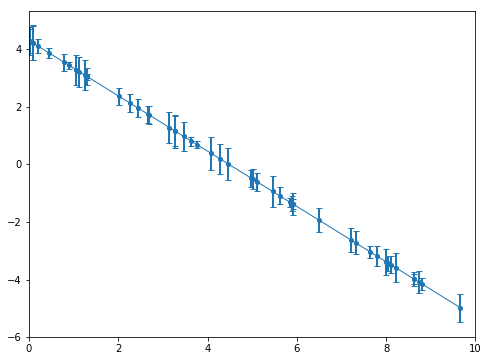

In [5]:
# plot the synthetic data
fig = plt.figure(figsize=(8,6))
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4, linewidth=1, linestyle='solid')
plt.xlim(0, 10)
plt.show()

In [6]:
# generate variation for y
y += np.abs(f_true*y) * np.random.randn(N)

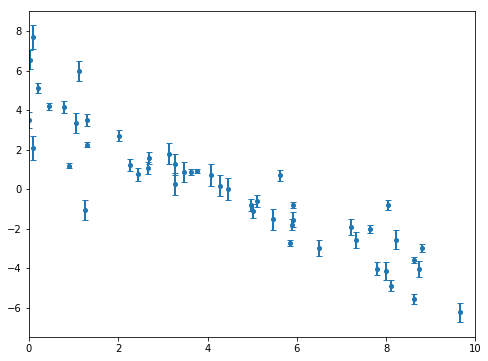

In [7]:
# plot the synthetic data
fig = plt.figure(figsize=(8,6))
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.show()

In [8]:
# generate more variation for y
y += yerr * np.random.randn(N)

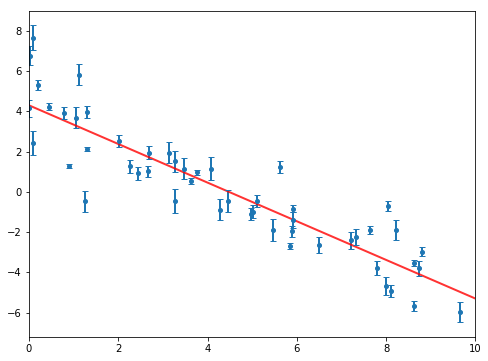

In [9]:
# plot the synthetic data along with perfect model
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.show()

In [10]:
# linear least squares solution to these data
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print(f"the results are: m={m_ls:.02f} and b={b_ls:.02f}")

the results are: m=-0.84 and b=3.56


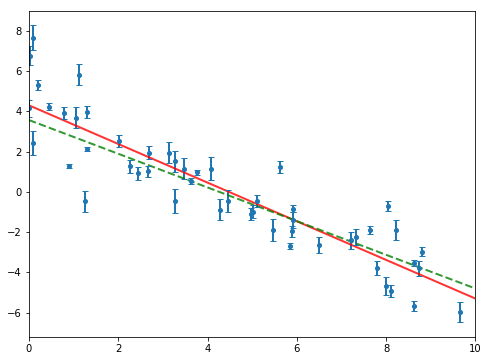

In [11]:
# plotted as a dashed green line
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="g", linestyle='dashed', lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.show()

In [12]:
# likelihood function is simply a Gaussian where the variance is underestimated by some fractional amount: f. 
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [13]:
# finding this numerical optimum of this likelihood function using the scipy.optimize module
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print(f"the results are m={m_ml:.02f}, b={b_ml:.02f} and f={np.e**(lnf_ml):.02f}")

the results are m=-0.96, b=4.14 and f=0.52


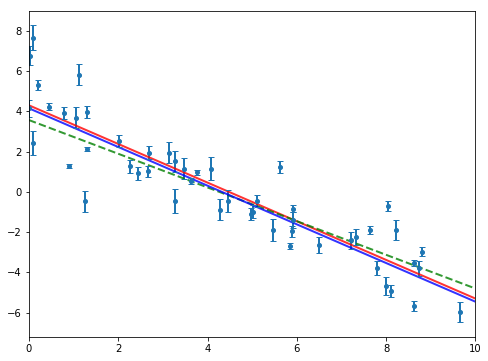

In [14]:
# plot all the data togther
xl = np.array([0, 10])
fig = plt.figure(figsize=(8,6))
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="g", linestyle='dashed', lw=2, alpha=0.8)
plt.plot(xl, m_ml*xl+b_ml, color="b", lw=2, alpha=0.8)
plt.errorbar(x,y, yerr=yerr, fmt='o', elinewidth=2, capsize=3, markersize=4)
plt.xlim(0, 10)
plt.show()

In [15]:
# write down priors if you’re going to use MCMC. the log-prior
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [16]:
# combine above with lnlike function: the full log-probability function 
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [17]:
# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# set up the sampler using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [18]:
# run the MCMC for 500 steps
foo = sampler.run_mcmc(pos, 500)

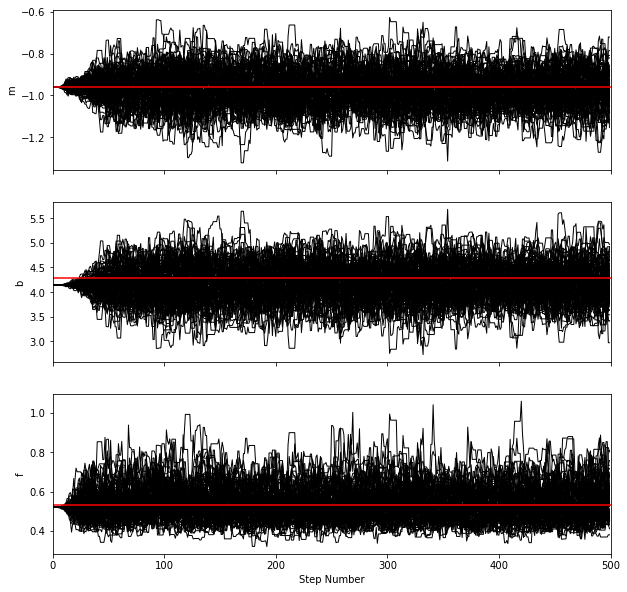

In [19]:
# plot positions of each walker as a function of the number of steps in the chain
x_axis = list(range(500))
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10,10))

for i in range(100):
    m_walk = []
    b_walk = []
    f_walk = []
    for j in range(500):
        m_walk.append(sampler.chain[i][j][0])
        b_walk.append(sampler.chain[i][j][1])
        f_walk.append(np.e**(sampler.chain[i][j][2]))
    ax1.plot(x_axis, m_walk, color='k', linewidth=1)
    ax2.plot(x_axis, b_walk, color='k', linewidth=1)
    ax3.plot(x_axis, f_walk, color='k', linewidth=1)
plt.xlim(0,500)
plt.xlabel("Step Number")
ax1.set_ylabel("m")
ax1.axhline(y=-0.9594, color='r', linestyle='-')
ax2.set_ylabel("b")
ax2.axhline(y=4.294, color='r', linestyle='-')
ax3.set_ylabel("f")
ax3.axhline(y=0.534, color='r', linestyle='-')
plt.show()

In [20]:
# discard the initial 50 steps and flatten the chain
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

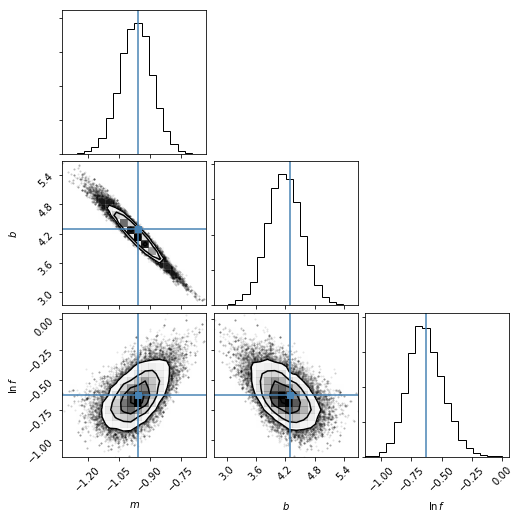

In [21]:
# based on MCMC results and generate a corner plot
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
plt.show()


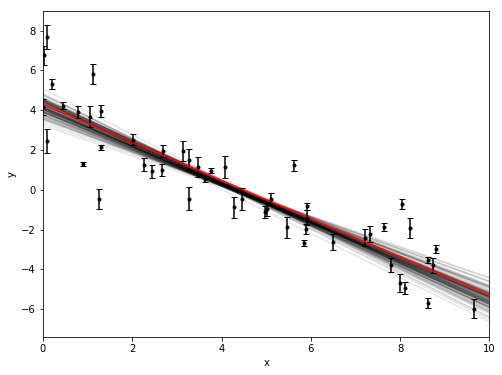

In [22]:
# choose a few (say 100 in this case) samples from the chain and plot them
fig = plt.figure(figsize=(8,6))
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=3)
plt.xlim(0,10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [23]:
# quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the 
# marginalized distributions
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [24]:
# print and compare results with true values
print(f"Final results: m={m_mcmc[0]:.4f}, b={b_mcmc[0]:.4f} and f={f_mcmc[0]:.4f}")
print(f"True values: m={m_true}, b={b_true} and f={f_true}")

Final results: m=-0.9658, b=4.1786 and f=0.5271
True values: m=-0.9594, b=4.294 and f=0.534
